In [1]:
# General and Data Libraries
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# Image Processing
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Model Building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Visualization Style
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

2025-10-31 12:53:38.672134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761915218.926207      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761915218.994596      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE = [300, 300]

EPOCHS=64
NUM_CLASSES = 1  # number of outputs
BATCH_SIZE = 64
VERBOSE = 1
DROPOUT=0.6
OPTIM = 'adam'

RANDOM_STATE = 42

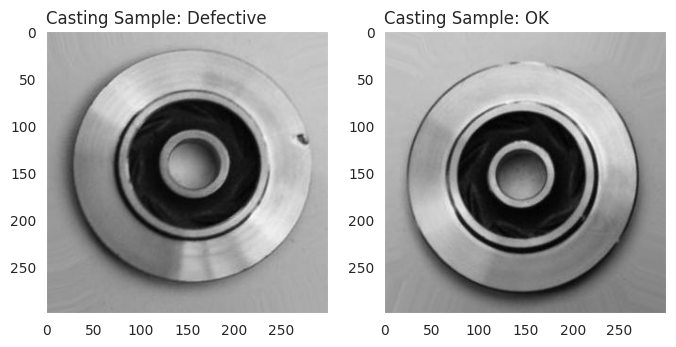

In [3]:
# Specify directory of train data
dir_train = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/train/'
dir_train_def = dir_train+'def_front/'  # Class label: Defective
dir_train_ok = dir_train+'ok_front/'    # Class label: OK

# Specify directory of test data
dir_test = '/kaggle/input/real-life-industrial-dataset-of-casting-product/casting_data/casting_data/test/'
dir_test_def = dir_test+'def_front/'
dir_test_ok = dir_test+'ok_front/'

# Plot samples of defective and non-defective casting
fig, axes = plt.subplots(1, 2, figsize=(8,4))
sample_def = plt.imread(dir_train_def+os.listdir(dir_train_def)[0])
sample_ok = plt.imread(dir_train_ok+os.listdir(dir_train_ok)[0])
axes[0].imshow(sample_def)
axes[1].imshow(sample_ok)
axes[0].set_title('Casting Sample: Defective', loc='left')
axes[1].set_title('Casting Sample: OK', loc='left')
axes[0].grid(False)
axes[1].grid(False)
plt.show()

In [4]:
def load_and_resize_images(image_paths, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])):
    images = []
    for path in image_paths:
        img = load_img(path, color_mode='grayscale', target_size=target_size)  # Load and resize
        img_array = img_to_array(img)  # Convert to array
        images.append(img_array)
    return np.array(images)

In [5]:
# Define classes
class_folders = ['def_front', 'ok_front']

def load_dataset(data_dir, class_folders):
    images, labels = [], []

    for class_name in class_folders:
        class_folder_path = os.path.join(data_dir, class_name)
        image_files = os.listdir(class_folder_path)
        image_paths = [os.path.join(class_folder_path, img) for img in image_files]
        
        class_images = load_and_resize_images(image_paths)
        images.append(class_images)
        labels.append([class_name] * len(image_files))

    X = np.concatenate(images, axis=0)
    y = np.concatenate(labels, axis=0)
    
    return X, y

# Load training and testing datasets
X_train, y_train = load_dataset(dir_train, class_folders)
X_test, y_test = load_dataset(dir_test, class_folders)

print("Shape of train images:", X_train.shape)
print("Shape of train labels:", y_train.shape)
print("Shape of test images:", X_test.shape)
print("Shape of test labels:", y_test.shape)

Shape of train images: (6633, 300, 300, 1)
Shape of train labels: (6633,)
Shape of test images: (715, 300, 300, 1)
Shape of test labels: (715,)


In [6]:
def preprocess_labels_and_images(X, y, label_encoder=None):
    if label_encoder is None:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
    else:
        y_encoded = label_encoder.transform(y)

    return X, y_encoded, label_encoder

# Train
X_train, y_train_encoded, label_encoder = preprocess_labels_and_images(X_train, y_train)

# Test
X_test, y_test_encoded, _ = preprocess_labels_and_images(X_test, y_test, label_encoder)

## Split Data

In [7]:
from sklearn.utils import shuffle

# Shuffle the train dataset
X_train, y_train_encoded = shuffle(X_train, y_train_encoded, random_state=RANDOM_STATE)

# Train/val split
train_images, val_images, train_labels, val_labels = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=RANDOM_STATE)

print(f"Shapes - train_images: {train_images.shape}, val_images: {val_images.shape}")
print(f"Shapes - train_labels: {train_labels.shape}, val_labels: {val_labels.shape}")

test_images, test_labels = shuffle(X_test, y_test_encoded, random_state=RANDOM_STATE)

Shapes - train_images: (5306, 300, 300, 1), val_images: (1327, 300, 300, 1)
Shapes - train_labels: (5306,), val_labels: (1327,)


# Data Exploration

In [8]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))

Number of training examples: 5306
Number of validation examples: 1327
Number of testing examples: 715
Training images are of shape: (5306, 300, 300, 1)
Training labels are of shape: (5306,)
Validation images are of shape: (1327, 300, 300, 1)
Validation labels are of shape: (1327,)
Test images are of shape: (715, 300, 300, 1)
Test labels are of shape: (715,)


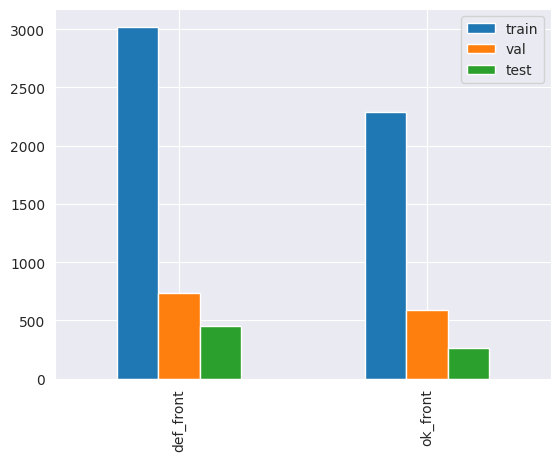

In [9]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_folders).plot.bar()

plt.show()

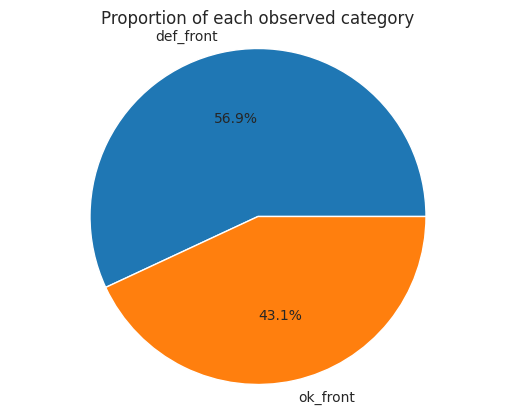

In [10]:
plt.pie(train_counts,
        explode=(0, 0) , 
        labels=class_folders,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# Data Reshaping

In [11]:
# Reshape to (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
X_train_reshaped = train_images.reshape(train_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
X_val_reshaped = val_images.reshape(val_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)
X_test_reshaped = test_images.reshape(test_images.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

# Model Building

In [12]:
# Define CNN model architecture
model = Sequential([
    Input(shape=IMAGE_SIZE + [1]),
    
    # Convolutional Backbone
    # First convolutional layer with padding, followed by ReLU activation
    Conv2D(32, 3, activation='relu', padding='same', strides=2),
    
    # Max pooling layer
    MaxPooling2D(pool_size=2, strides=2),
    
    # Second convolutional layer with padding, followed by ReLU activation
    Conv2D(64, 3, activation='relu', padding='same', strides=2),
    
    # Max pooling layer
    MaxPooling2D(pool_size=2, strides=2),

    # Third convolutional layer with padding, followed by batch normalization and ReLU activation
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(0.01), use_bias=False),
    BatchNormalization(),
    Activation('relu'),

    # Max pooling layer
    MaxPooling2D(),
    
    # Flatenning
    Flatten(),
    
    # Dense Classifier
    Dense(64, activation='relu'),
    Dropout(DROPOUT),
    Dense(NUM_CLASSES, activation='sigmoid')        # Only 1 output
])

I0000 00:00:1761915290.568219      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 38, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 19, 19, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       663,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 756,737 (2.89 MB)

 Trainable params: 756,481 (2.89 MB)

 Non-trainable params: 256 (1.00 KB)

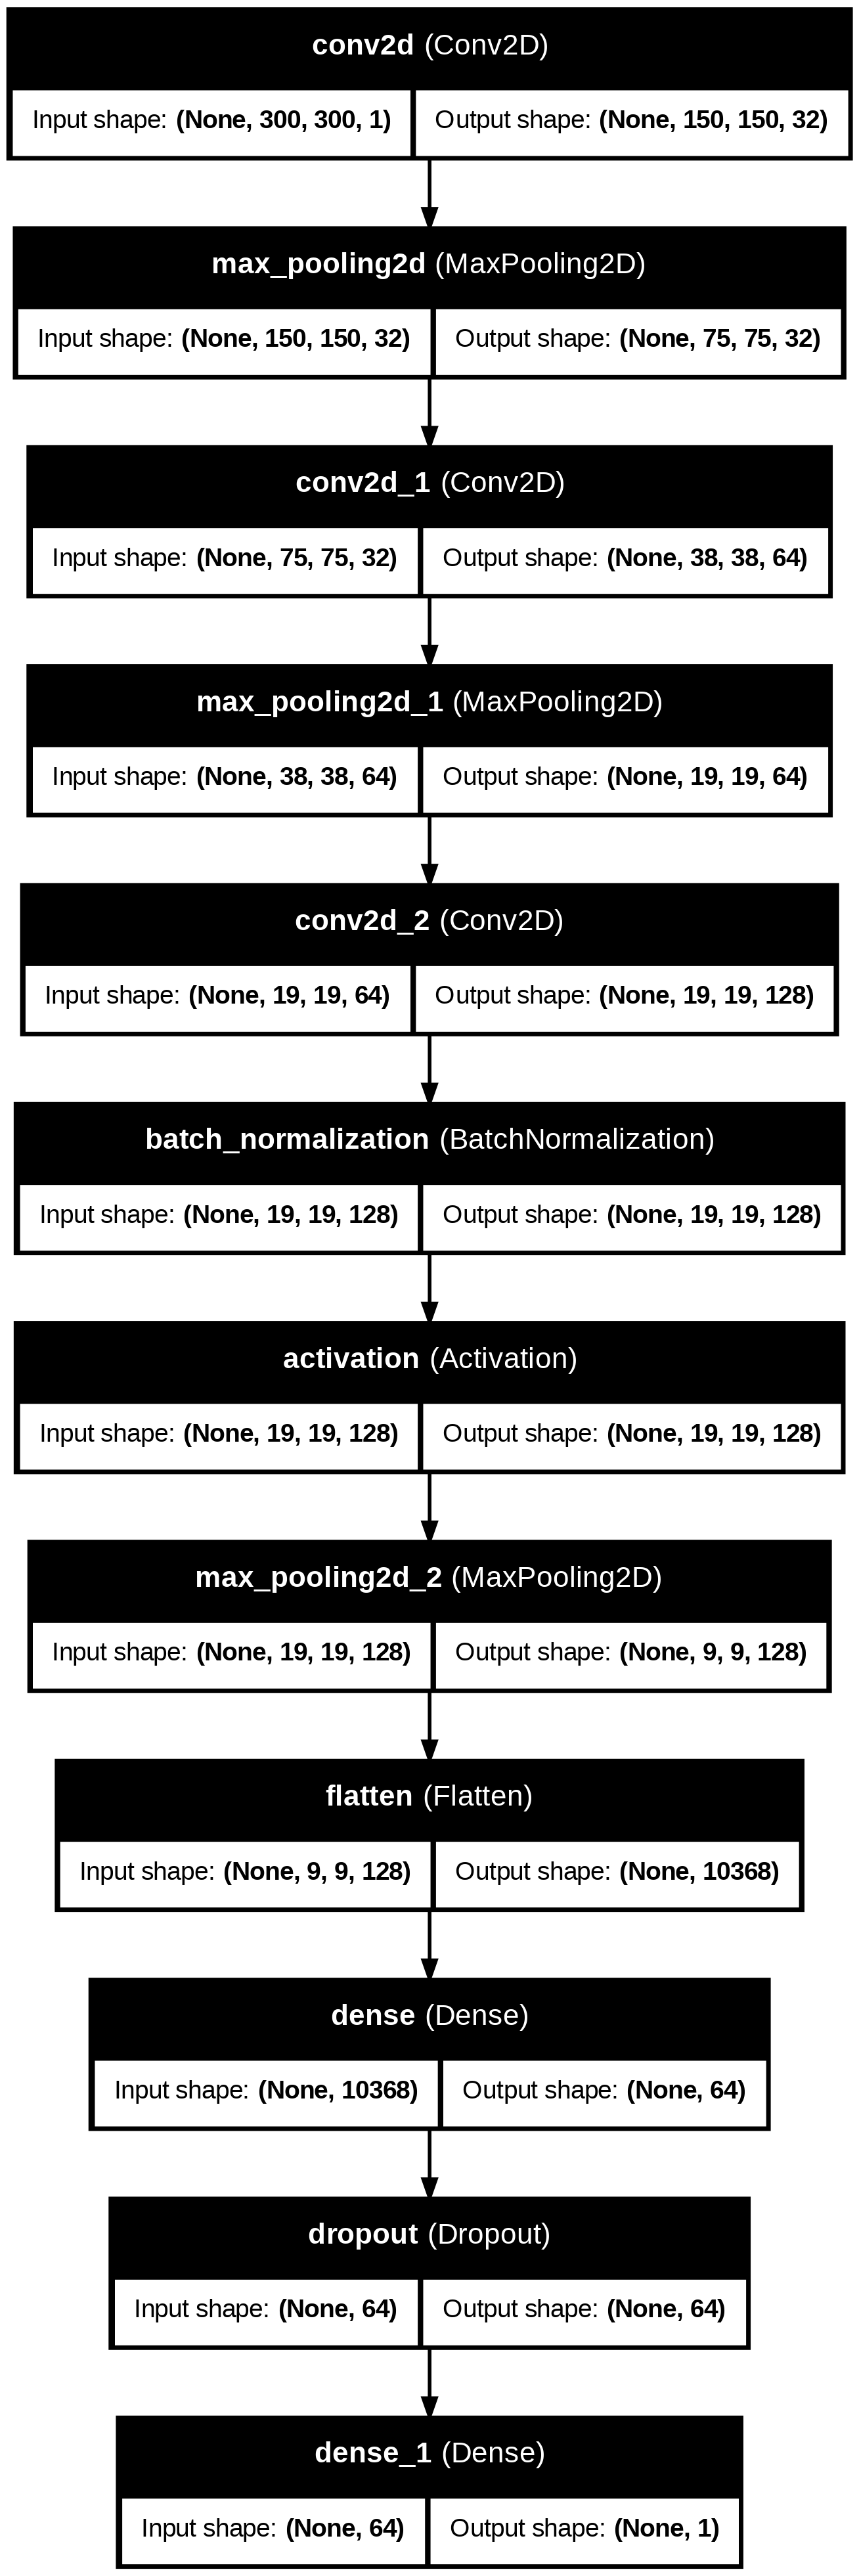

In [14]:
from keras.utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [15]:
# Compile model
model.compile(
    optimizer=OPTIM,
    loss='binary_crossentropy',
    metrics=['accuracy'])

# Model Training

In [16]:
# Callbacks with Early Stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=VERBOSE),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=VERBOSE)
]

history = model.fit(
    X_train_reshaped, 
    train_labels, 
    validation_data=(X_val_reshaped, val_labels), 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks)

Epoch 1/64


I0000 00:00:1761915299.766313      61 service.cc:148] XLA service 0x7a600400fc70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761915299.767345      61 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1761915300.152879      61 cuda_dnn.cc:529] Loaded cuDNN version 90300


 6/83 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5137 - loss: 6.0845

I0000 00:00:1761915303.567358      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


83/83 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.5744 - loss: 3.4508 - val_accuracy: 0.4446 - val_loss: 1.6336 - learning_rate: 0.0010
Epoch 2/64
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6982 - loss: 1.2840 - val_accuracy: 0.8621 - val_loss: 0.8008 - learning_rate: 0.0010
Epoch 3/64
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7479 - loss: 0.7972 - val_accuracy: 0.5554 - val_loss: 3.5125 - learning_rate: 0.0010
Epoch 4/64
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7673 - loss: 0.6181 - val_accuracy: 0.8757 - val_loss: 0.4875 - learning_rate: 0.0010
Epoch 5/64
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7563 - loss: 0.5517 - val_accuracy: 0.5554 - val_loss: 5.1341 - learning_rate: 0.0010
Epoch 6/64
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7909 - loss: 0.4842 - val_accuracy: 0.5554 - val_loss: 4.3769 - learning_rate: 0.0010
Epoch 7/64
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7859 - loss: 0.4741
Epoch 7: ReduceLROn

# Evaluating performance
## Plot Training Metrics
Visualize training and validation accuracy/loss.

In [17]:
# Plotting Training and Validation Metrics
def plot_training(hist):
    # Extracting accuracy and loss values
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Finding the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Plot settings
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

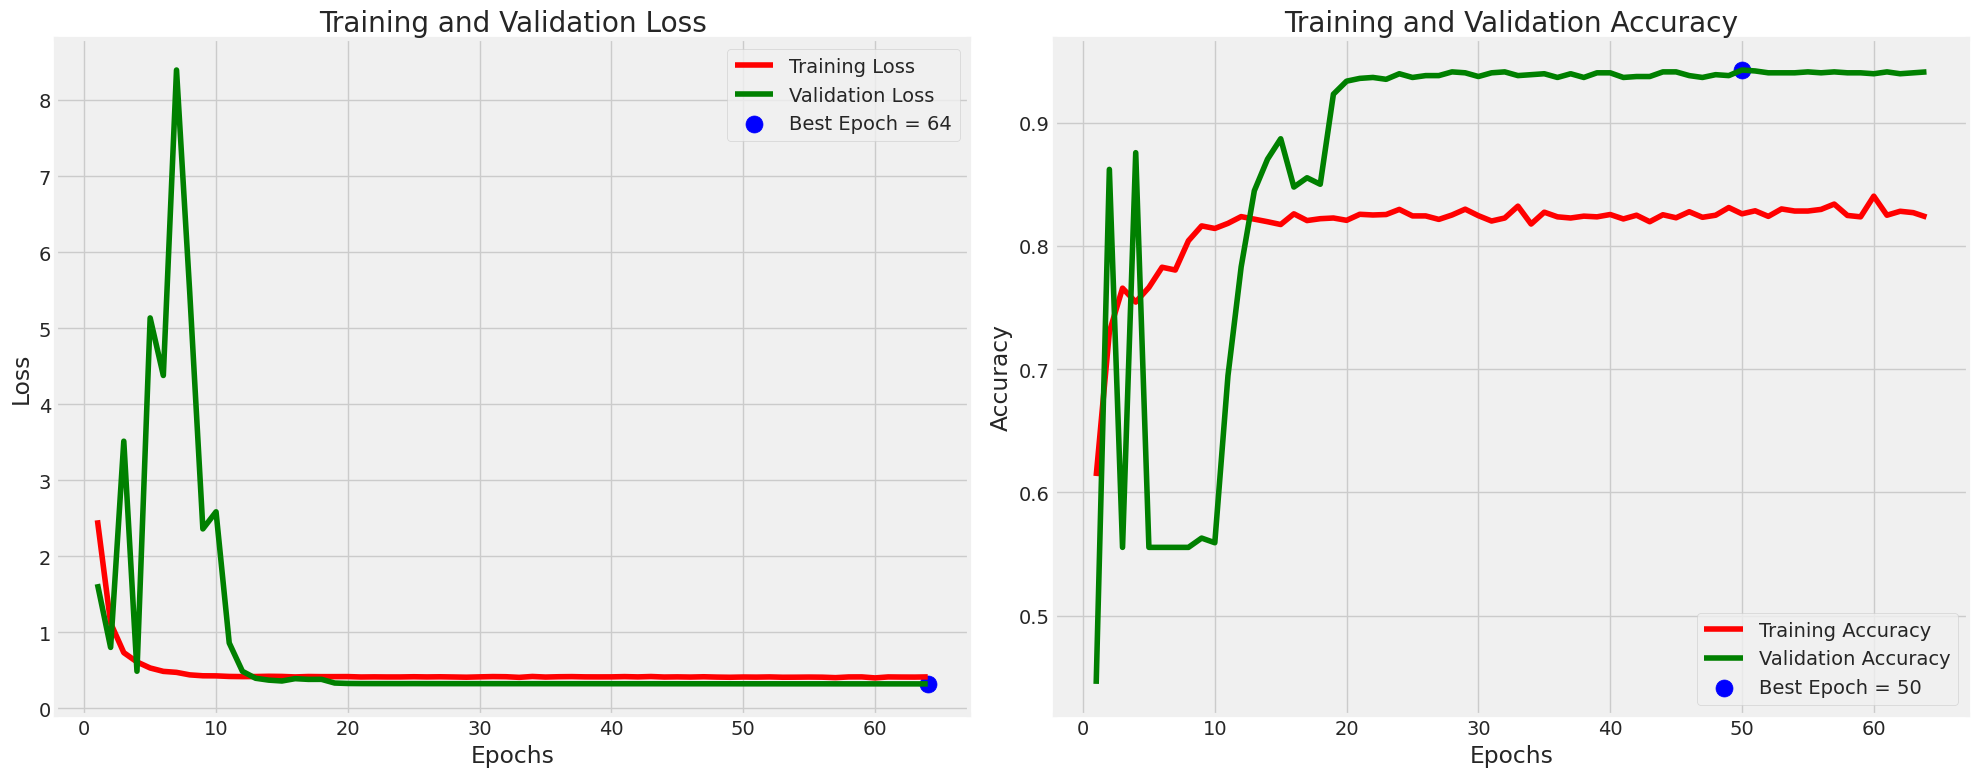

In [18]:
plot_training(history)

## Test Performance
Lets evaluate the model on test data to find the loss and accuracy:

In [19]:
test_loss, test_accuracy = model.evaluate(X_test_reshaped, test_labels, verbose=VERBOSE)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9245 - loss: 0.2786
Test Accuracy: 92.59%
Test Loss: 0.2882


## Classification Report and Confusion Matrix
Assess performance per class.

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

   def_front       0.97      0.91      0.94       453
    ok_front       0.86      0.95      0.90       262

    accuracy                           0.93       715
   macro avg       0.92      0.93      0.92       715
weighted avg       0.93      0.93      0.93       715



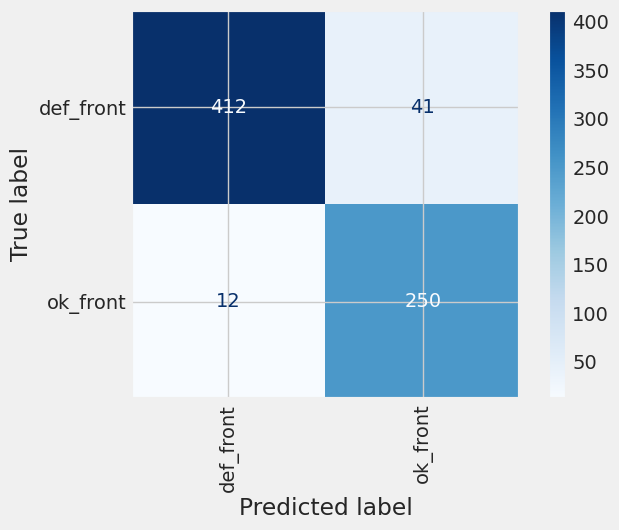

In [20]:
y_pred_prob = model.predict(test_images)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_labels

print(classification_report(y_true, y_pred, target_names=class_folders))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_folders)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.show()

The metric recall helps us evaluate model performance when the cost of false negatives is high. Alternatively, when the cost of false positives is high, the metric precision is prioritized. However, since both cases of misclassification negatively impact the business, F1-score can be selected as a performance metric. F1-score is an overall measure of a model's accuracy that combines precision and recall.

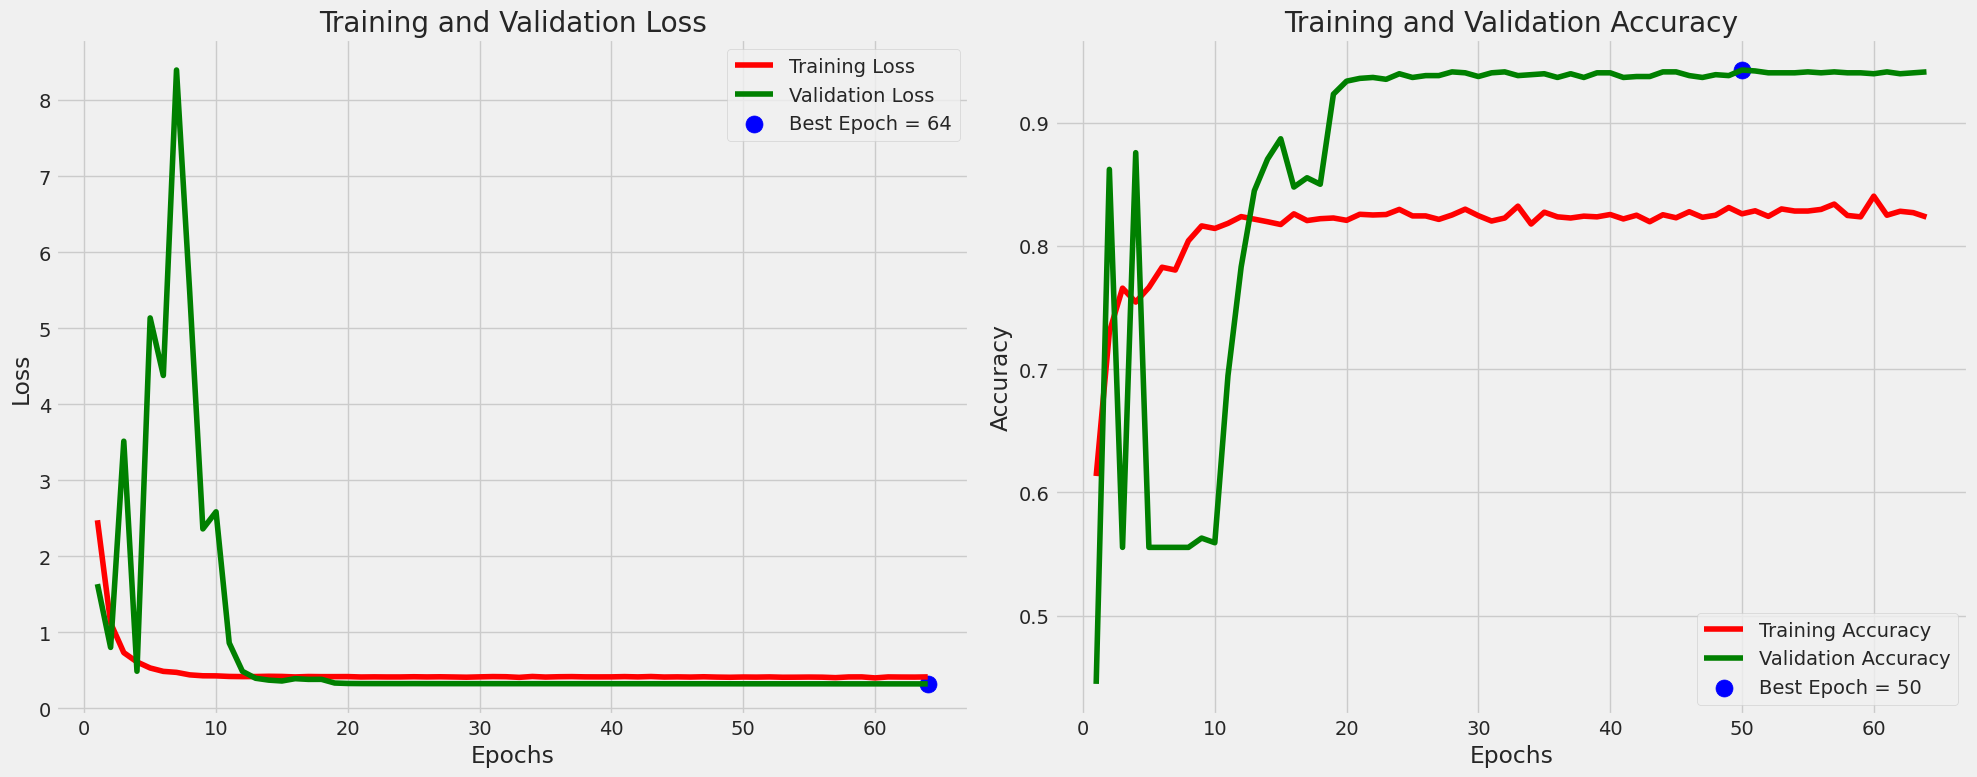

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training(hist):
    '''
    This function takes the history object returned by model.fit()
    and plots the training and validation accuracy and loss curves.
    '''
    # Extracting accuracy and loss values
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    # Finding the best epochs for loss and accuracy
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    # Plot settings
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')
    epochs = [i + 1 for i in range(len(tr_acc))]
    loss_label = f'Best Epoch = {index_loss + 1}'
    acc_label = f'Best Epoch = {index_acc + 1}'

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'g', label='Validation Loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training(history)

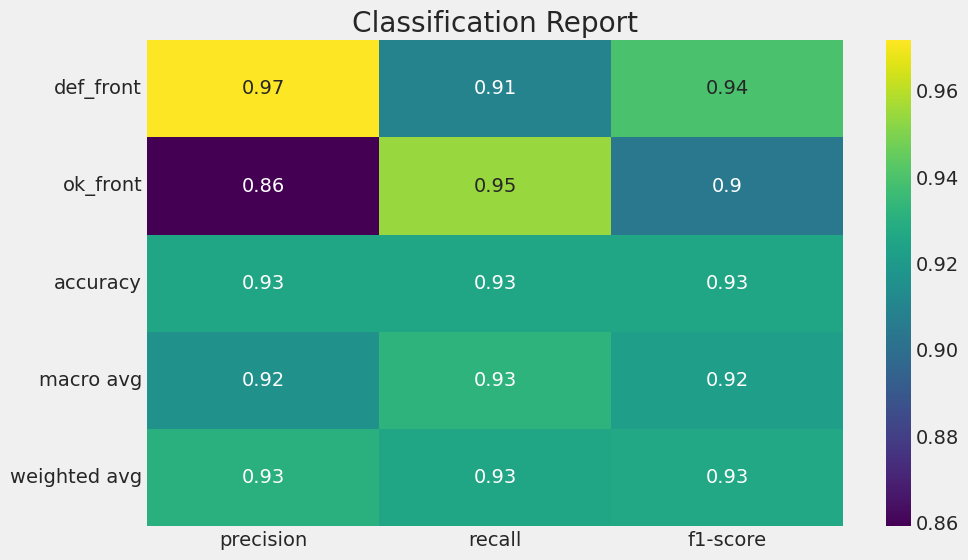

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report(y_true, y_pred, target_names):
    '''
    This function takes the true and predicted labels and target names,
    and plots the classification report as a heatmap.
    '''
    report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
    df_report = pd.DataFrame(report).iloc[:-1, :].T

    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report, annot=True, cmap='viridis')
    plt.title('Classification Report')
    plt.show()

plot_classification_report(y_true, y_pred, class_folders)

In [23]:
import matplotlib.pyplot as plt

def plot_model_performance(history):
    """
    Plots the training and validation accuracy and loss from a Keras history object.

    Args:
      history: A Keras History object returned by the model.fit() method.
    """
    # Set the style for the plots
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # --- Plot 1: Model Accuracy ---
    axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='dodgerblue', marker='o', linestyle='--')
    axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='darkorange', marker='x', linestyle='-')
    axes[0].set_title('Model Accuracy Over Epochs', fontsize=16, fontweight='bold')
    axes[0].set_xlabel('Epochs', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(loc='lower right', fontsize=10)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

    # --- Plot 2: Model Loss ---
    axes[1].plot(history.history['loss'], label='Training Loss', color='crimson', marker='o', linestyle='--')
    axes[1].plot(history.history['val_loss'], label='Validation Loss', color='purple', marker='x', linestyle='-')
    axes[1].set_title('Model Loss Over Epochs', fontsize=16, fontweight='bold')
    axes[1].set_xlabel('Epochs', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(loc='upper right', fontsize=10)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

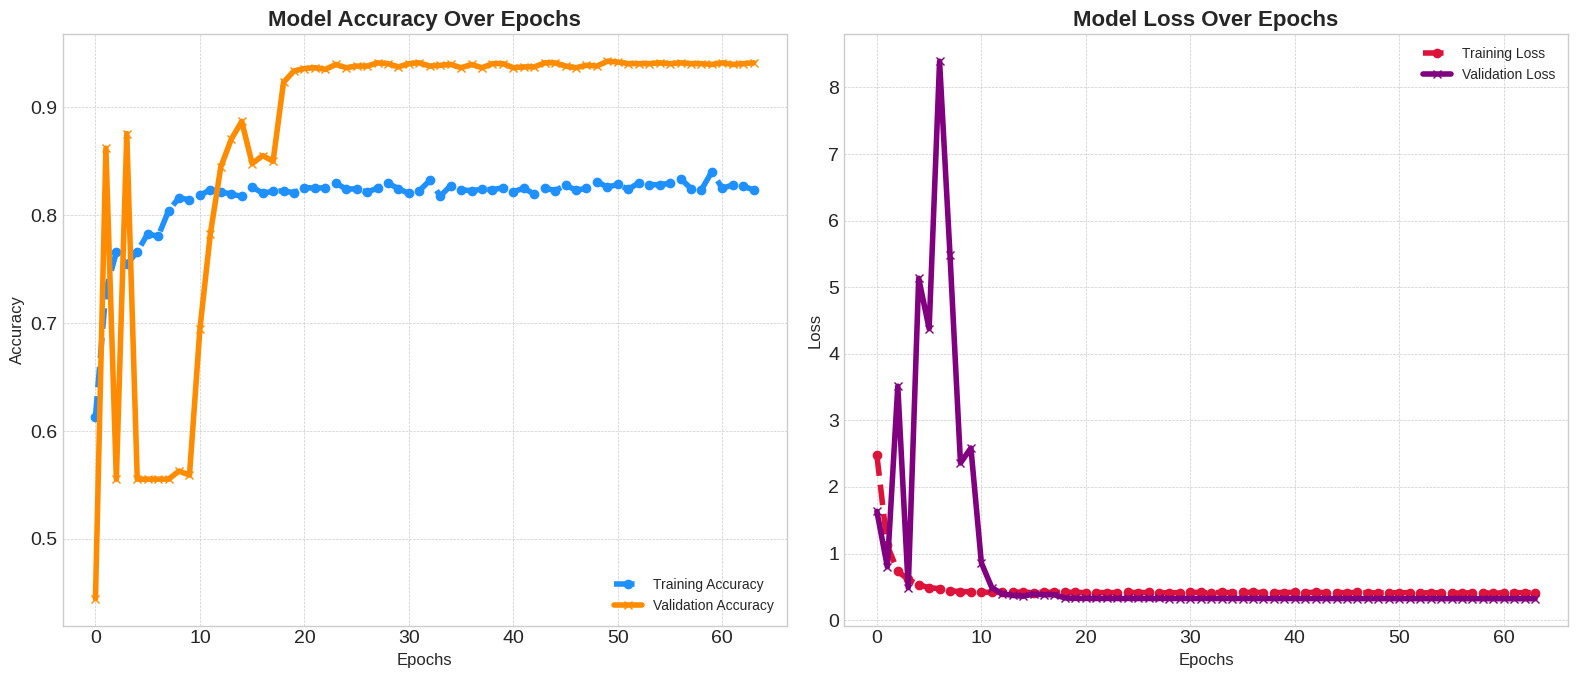

In [24]:
plot_model_performance(history)

In [25]:
# Save model
model.save("CastingModel.h5")